# Nino3.4 and California DJF precip correlation : emerging constraint in CMIP6? 
### from Allen & Lupowitz (2017) DOI: 10.1038/ncomms16055

In [1]:
#!pip install -u geopandas
#!pip install -u regionmask

In [2]:
# Loading libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import dask
import season_util as su
import jetlatcalcs as jlat
import mask

you have successfully imported the jet latitude calculation subroutines


In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Find/read ts data:

In [4]:
#historical simulations
import intake
var1 = ["ts"]
model=['AWI-CM-1-MR','BCC-CSM2-MR','CAMS-CSM1-0', 'CanESM5','MIROC-ES2L','MIROC6','UKESM1-0-LL','MRI-ESM2-0']
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="CMIP",experiment_id="historical", variable_id=var1,
table_id="Amon", grid_label="gn", source_id=model )
dset_dict_hist_ts = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)


In [5]:
#ssp simulations
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="ScenarioMIP",experiment_id="ssp370", variable_id=var1,
table_id="Amon", grid_label="gn", source_id=model )
dset_dict_ssp370_ts = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)


#### Calculate Nino3.4 time series:

In [6]:
#subset for time period (1948 through 2014)
hist_ts = {}
for key, ds in dset_dict_hist_ts.items():
    hist_ts[key] = ds.sel(time = slice('1948-01-01','2015-01-01'))

In [7]:
from nino34 import nino34

In [8]:
# usage: nino = nino34(da,'ts','DJF')
hist_nino = {}
for key in hist_ts:
    print(key)
    # calculate index and drop first year!
    hist_nino[key] = nino34(hist_ts[key], 'ts', 'DJF').values[:,1:]
    ## add days per month weighting in DJF calc

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.MIROC.MIROC-ES2L.historical.Amon.gn
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn


#### Find/read pr data:

In [10]:
#historical simulations
import intake
var2 = ["pr"]
model=['AWI-CM-1-MR','BCC-CSM2-MR','CAMS-CSM1-0', 'CanESM5','MIROC-ES2L','MIROC6','UKESM1-0-LL','MRI-ESM2-0']
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="CMIP",experiment_id="historical", variable_id=var2,
table_id="Amon", grid_label="gn", source_id=model )
dset_dict_hist = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)


In [11]:
#ssp simulations
col = intake.open_esm_datastore("/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.json")
cat = col.search(activity_id="ScenarioMIP",experiment_id="ssp370", variable_id=var2,
table_id="Amon", grid_label="gn", source_id=model )
dset_dict_ssp370 = cat.to_dataset_dict(cdf_kwargs={'chunks': {"time": 36}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)


In [12]:
#subset for time period (1948 through 2014)
hist = {}
for key, ds in dset_dict_hist.items():
    hist[key] = ds.sel(time = slice('1948-01-01','2015-01-01'))

#### Calculate DJF precip time series for California:

In [15]:
hist_ca_pr = {}
for key in hist:
    print(key)
    ca_mask = mask.state_mask(mask.read_state("../data/states.shp", 'California'), hist[key], 'California', 'CA')
    # calculate CA DJF precip and drop first year
    hist_ca_pr[key] = su.season_ts((hist[key].where(ca_mask == 1)), "pr", "DJF").mean(dim=('lat', 'lon')).values[:,1:]
## add days per month weighting and areacella weighting

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.MIROC.MIROC-ES2L.historical.Amon.gn
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn


#### Detrend time series

In [18]:
from scipy import signal

In [19]:
ca_pr_dtr = {}
for key in hist_ca_pr:
    print(key)
    ca_pr_dtr[key] = signal.detrend(hist_ca_pr[key])

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.MIROC.MIROC-ES2L.historical.Amon.gn
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn


In [20]:
#nino_dtr

In [21]:
nino_dtr = {}
for key in hist_nino:
    print(key)
    nino_dtr[key] = signal.detrend(hist_nino[key])

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.MIROC.MIROC-ES2L.historical.Amon.gn
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn


#### Calculate interannual correlation between Nino3.4 and CA DJF precip: (TO DO)

In [22]:
#x = nino_dtr[key][2,:]
#y = ca_pr_dtr[key][2,:]
#print(x, y)
#np.corrcoef(x,y)[0,1]

In [23]:
#plt.plot(x,y, linestyle = 'none', marker = 'o')

In [52]:
hist_cor = {}
for key in nino_dtr:
    print(key)
    #hist_cor[key] = signal.correlate2d(nino_dtr[key], ca_pr_dtr[key])

CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn
CMIP.MIROC.MIROC-ES2L.historical.Amon.gn
CMIP.MIROC.MIROC6.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn


In [ ]:
#key = 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn'
#test = xr.Dataset(nino_dtr[key]).merge(xr.Dataset(ca_pr_dtr[key]))

In [ ]:
#hist_cor

#### Calculate mean correlation across ensembles members within each model: (TO DO)

#### Calculate mean DJF precip in historical and future periods: 

In [51]:
hist_mean = {}
for key, ds in dset_dict_hist.items():
    hist_mean[key] = su.season_mean(ds.sel(time = slice('1979-01-01','2006-01-01')),
                                       var="pr", season="DJF").mean(dim=('member_id'))
#hist_mean = list(hist_mean.values())
    
ssp370_mean = {}
for key, ds in dset_dict_ssp370.items():
    ssp370_mean[key] = su.season_mean(ds.sel(time = slice('2070-01-01','2099-01-01')),
                                         var="pr", season="DJF").mean(dim=('member_id'))
#ssp370_mean = list(ssp370_mean.values())


In [ ]:
## CALCULATE CALIFORNIA AVERAGE PRECIP
#hist_ca_mean = {}
#for key, ds in dset_dict_hist.items():
#    ca_mask = mask.state_mask(mask.read_state("../data/states.shp", 'California'), ds, 'California', 'CA')
#    hist_ca_mean[key] = su.season_mean(ds.sel(time = slice('1979-01-01','2006-01-01')).where(ca_mask==1),
#                                       var="pr", season="DJF").mean(dim=('lat', 'lon','member_id'))
#hist_ca_mean = list(hist_ca_mean.values())
    
#ssp370_ca_mean = {}
#for key, ds in dset_dict_ssp370.items():
#    ca_mask = mask.state_mask(mask.read_state("../data/states.shp", 'California'), ds, 'California', 'CA')
#    ssp370_ca_mean[key] = su.season_mean(ds.sel(time = slice('2070-01-01','2099-01-01')).where(ca_mask==1),
#                                         var="pr", season="DJF").mean(dim=('lat', 'lon', member_id'))
#ssp370_ca_mean = list(ssp370_ca_mean.values())

## 2070-2099 Precip (SPP370) - 1979-2005 Precip

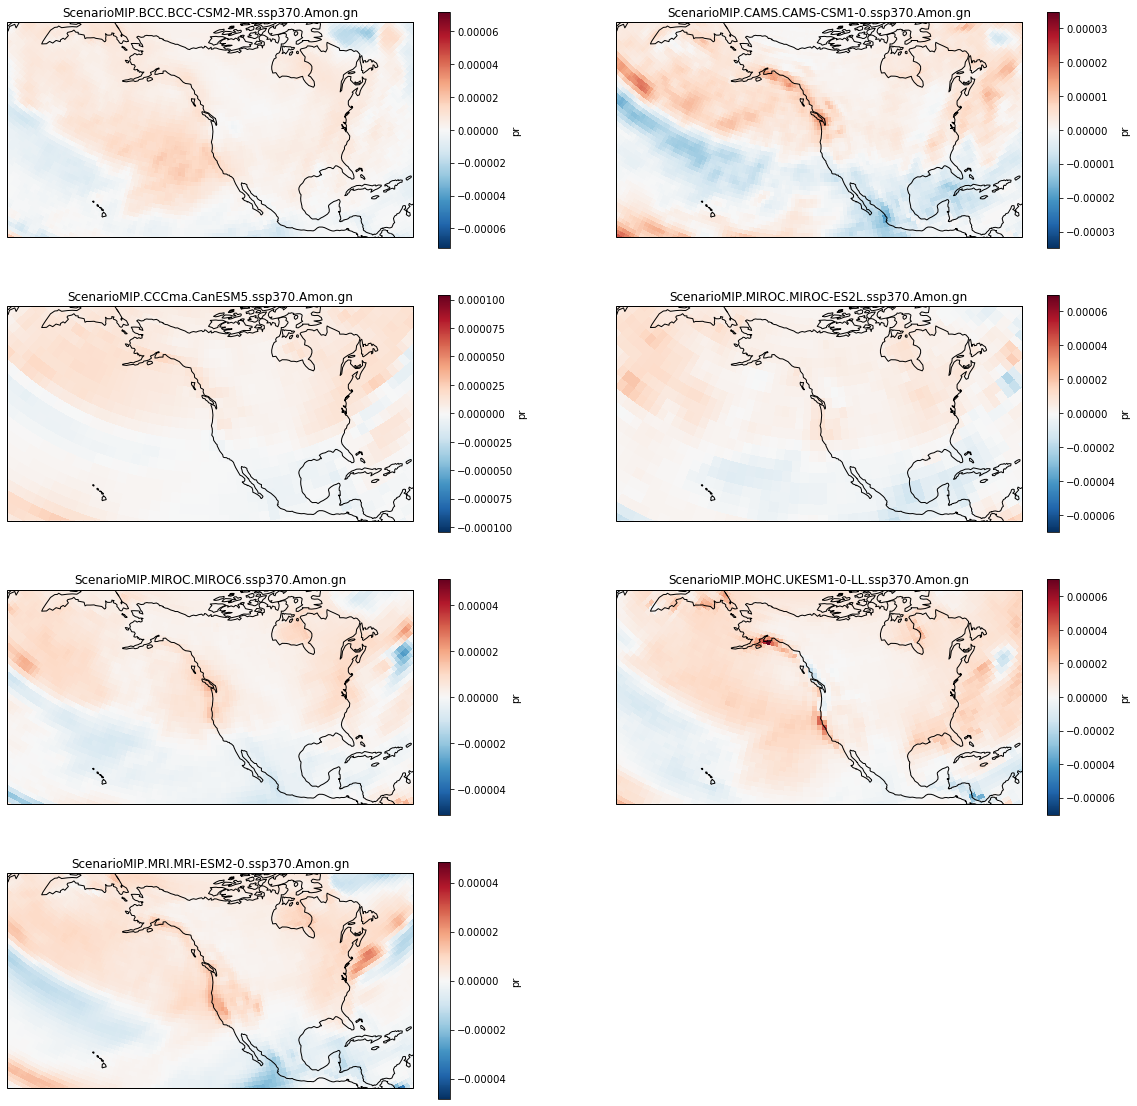

In [53]:
# load cartopy
import cartopy.crs as ccrs

extent = [-180, -70, 10, 70]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
fig = plt.figure(figsize=(20, 20))
#ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
for key1, key2, i in zip(ssp370_mean, hist_mean, range(7)): 
    ax = fig.add_subplot(4, 2, (i+1), projection=ccrs.AlbersEqualArea(central_lon, central_lat))
    s = (ssp370_mean[key1] - hist_mean[key2]).plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree())
    ax.set_extent(extent)
    ax.coastlines()
    ax.set_title(key1)
